## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Шавандрин |
|---------|--------|
| Группа  | 8      |

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.model_selection import train_test_split
import pylab
import pandas as pd
from matplotlib import gridspec
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [2]:
import pickle
with open('./datasets/mnist.pkl','rb') as f:
    MNIST = pickle.load(f)

In [3]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Смотрим на то, какие данные получились:

In [4]:
data.shape

(42000, 784)

Используйте Scikit Learn для разбиения данных на обучающую и тестовую выборку

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.25, random_state=66)

In [6]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

In [7]:
class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

In [8]:
eps = 1e-8

class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y + eps)
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / (self.p + eps)

Передаточные функции(функции активации):

In [9]:
class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

In [10]:
class Relu:
    def forward(self, x):
        self.input = x
        y = np.maximum(x, 0)
        self.y = y
        return y
    def backward(self, dy):
        mask = self.input > 0
        res = np.multiply(dy, mask)
        return res

In [11]:
def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=32, lr=2e-5):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)


def get_loss_acc(x,y,net,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

In [12]:
def draw(n_epochs, lst, label1, label2):
    fig = plt.figure()
    
    ax = fig.add_axes([0,0,1,1])

    ax.plot(np.array([i for i in range(n_epochs)]), lst[0], 'r.-', label=label1)
    ax.plot(np.array([i for i in range(n_epochs)]), lst[1], 'g--', label=label2)
    plt.legend()
    plt.show()

def get_conf_matrix(net, X_test, y_true, labels):
    y_pred = net.forward(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    cf_matrix = confusion_matrix(y_true, y_pred)
    disp=ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=labels)
    fig, ax = plt.subplots(figsize=(10,10))
    disp.plot(ax=ax);

### MNIST

In [13]:
np.random.seed(3183)

# 1-слойный персептрон
mnist_1 = Net()
mnist_1.add(Linear(784, 10))
mnist_1.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_1, loss)))
for i in range(n_epochs):
    train_epoch(mnist_1, X_train, y_train, loss)
    l_train, acc_tr = get_loss_acc(X_train, y_train, mnist_1, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, mnist_1, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=16.479778378316215, accuracy=0.08574603174603175: 
1: loss=10.10743126494128, accuracy=0.4317142857142857: 
2: loss=8.695985619176513, accuracy=0.5089206349206349: 
3: loss=7.382745683055524, accuracy=0.5797777777777777: 
4: loss=6.655747524813247, accuracy=0.6216507936507937: 
5: loss=6.270598324886678, accuracy=0.6435555555555555: 
6: loss=6.001166095991515, accuracy=0.6600952380952381: 
7: loss=5.611782316897563, accuracy=0.6793015873015873: 
8: loss=5.197310917520774, accuracy=0.6989206349206349: 
9: loss=4.037601976435459, accuracy=0.7613333333333333: 
10: loss=2.94626639414444, accuracy=0.8169206349206349: 
11: loss=2.423669984380505, accuracy=0.8486349206349206: 
12: loss=2.208393112710314, accuracy=0.8606666666666667: 
13: loss=2.0836793833952, accuracy=0.8682222222222222: 
14: loss=2.002257168276742, accuracy=0.8731746031746032: 
15: loss=1.9468131674256732, accuracy=0.8760952380952381: 
16: loss=1.887255046062425, accuracy=0.8792698412698413: 
17: loss=1.83802934

### Графики loss и accuracy для обучающей и тестовой выборки для 1-слойного персептрона.

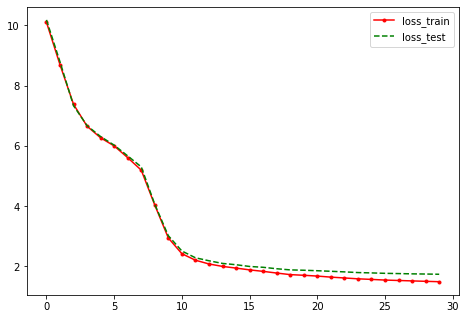

In [14]:
# loss на обучающей и тестовой выборке

draw(n_epochs, [loss_train, loss_test], 'loss_train', 'loss_test')

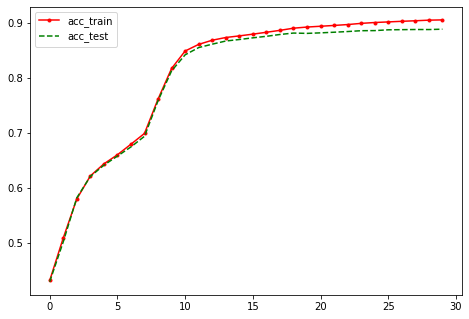

In [15]:
# accuracy на обучающей и тестовой выборке

draw(n_epochs, [acc_train, acc_test], 'acc_train', 'acc_test')

Точность 1-слойной модели на обучающей и тестовой выборке:

In [16]:
# 1-layer model
print("Training: loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_1)))
print("Test: loss={}, accuracy={}: ".format(*get_loss_acc(X_test, y_test, mnist_1)))

Training: loss=1.4946960767517166, accuracy=0.9051746031746032: 
Test: loss=1.7416731946813788, accuracy=0.8882857142857142: 


### Матрица неточности для 1-слойной модели

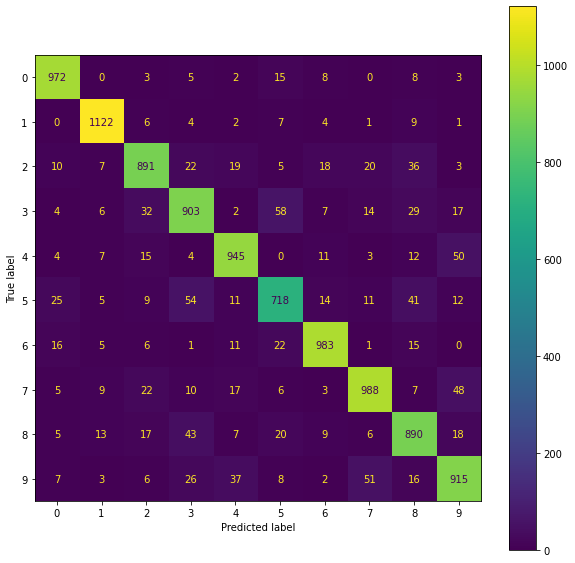

In [17]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
get_conf_matrix(mnist_1, X_test, y_test, labels)

In [18]:
# 2-слойный персептрон с функцией активации Tanh()

np.random.seed(3183)

mnist_2 = Net()
mnist_2.add(Linear(784, 128))
mnist_2.add(Tanh())
mnist_2.add(Linear(128, 10))
mnist_2.add(Softmax())
loss = CrossEntropyLoss()

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_2, loss)))
for i in range(n_epochs):
    train_epoch(mnist_2, X_train, y_train, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, *get_loss_acc(X_train, y_train, mnist_2, loss)))

Initial loss=2.5688529543996124, accuracy=0.11606349206349206: 
1: loss=2.306189674025071, accuracy=0.17974603174603174: 
2: loss=2.102673402111158, accuracy=0.2557142857142857: 
3: loss=1.9373454843816298, accuracy=0.3294920634920635: 
4: loss=1.8063410316725246, accuracy=0.3939047619047619: 
5: loss=1.6973841675563248, accuracy=0.4462857142857143: 
6: loss=1.6039977761065285, accuracy=0.4916190476190476: 
7: loss=1.5237113749848574, accuracy=0.529015873015873: 
8: loss=1.4557264970527497, accuracy=0.5572698412698412: 
9: loss=1.3971289736431933, accuracy=0.5833650793650794: 
10: loss=1.3470404025440526, accuracy=0.6045714285714285: 
11: loss=1.2995517418911722, accuracy=0.6242222222222222: 
12: loss=1.2569449629206202, accuracy=0.640095238095238: 
13: loss=1.2195313569279675, accuracy=0.6537142857142857: 
14: loss=1.1854794754036013, accuracy=0.6660952380952381: 
15: loss=1.154431062977602, accuracy=0.6775555555555556: 
16: loss=1.126512954960533, accuracy=0.686952380952381: 
17: los

Точность 2-слойной модели с функцией активацией Tanh() на обучающей и тестовой выборке:

In [19]:
# 2-layer model with Tanh()
print("Training: loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_2)))
print("Test: loss={}, accuracy={}: ".format(*get_loss_acc(X_test, y_test, mnist_2)))

Training: loss=0.8666202863233597, accuracy=0.7707619047619048: 
Test: loss=0.8900058137215514, accuracy=0.7593333333333333: 


In [20]:
# 2-слойный персептрон с функцией активации Relu()

np.random.seed(3183)

mnist_2 = Net()
mnist_2.add(Linear(784, 128 ))
mnist_2.add(Relu())
mnist_2.add(Linear(128 , 10))
mnist_2.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_2, loss)))
for i in range(n_epochs):
    train_epoch(mnist_2, X_train, y_train, loss)
    l_train, acc_tr = get_loss_acc(X_train, y_train, mnist_2, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, mnist_2, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=14.56185004780453, accuracy=0.1783809523809524: 
1: loss=9.202390042708778, accuracy=0.4596825396825397: 
2: loss=7.10982062684893, accuracy=0.5804444444444444: 
3: loss=6.270626276144265, accuracy=0.6292698412698413: 
4: loss=5.092566047200662, accuracy=0.686: 
5: loss=4.388948548481598, accuracy=0.7313015873015873: 
6: loss=4.061740725771971, accuracy=0.7507619047619047: 
7: loss=3.8637525274610707, accuracy=0.7625714285714286: 
8: loss=3.7222457913762668, accuracy=0.7721269841269841: 
9: loss=3.6104462299971694, accuracy=0.7794603174603174: 
10: loss=3.514019920294592, accuracy=0.786984126984127: 
11: loss=3.4445676458928016, accuracy=0.7918730158730158: 
12: loss=3.382905202176479, accuracy=0.7967619047619048: 
13: loss=3.334763478606945, accuracy=0.8002857142857143: 
14: loss=3.2918833141934187, accuracy=0.8035238095238095: 
15: loss=3.2543315632113807, accuracy=0.8055555555555556: 
16: loss=3.217699722729938, accuracy=0.8078412698412698: 
17: loss=3.1868485231797306,

### Графики loss и accuracy для обучающей и тестовой выборки для 2-слойного персептрона.

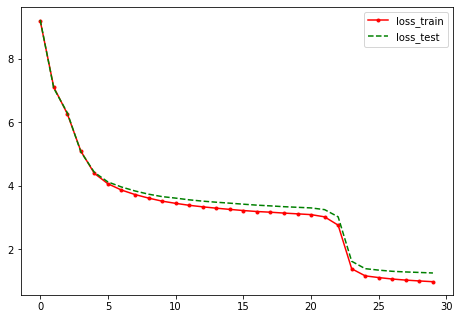

In [21]:
# loss на обучающей и тестовой выборке

draw(n_epochs, [loss_train, loss_test], 'loss_train', 'loss_test')

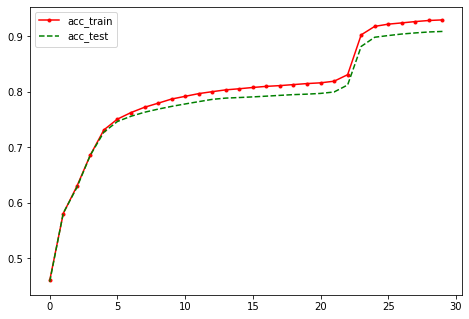

In [22]:
# accuracy на обучающей и тестовой выборке

draw(n_epochs, [acc_train, acc_test], 'acc_train', 'acc_test')

Точность 2-слойной модели с функцией активацией Relu() на обучающей и тестовой выборке:

In [23]:
# 2-layer model with Relu()
print("Training: loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_2)))
print("Test: loss={}, accuracy={}: ".format(*get_loss_acc(X_test, y_test, mnist_2)))

Training: loss=0.9732793959471185, accuracy=0.9297777777777778: 
Test: loss=1.2483583912923983, accuracy=0.908952380952381: 


Из анализа точностей для 2-слойных моделей с передаточными функциями Tanh() и Relu(), можно сделать вывод, что Relu() лучше, чем Tanh(). Поэтому для 3-слойной модели буду использовать именно её.

### Матрица неточности для 2-слойного персептрона

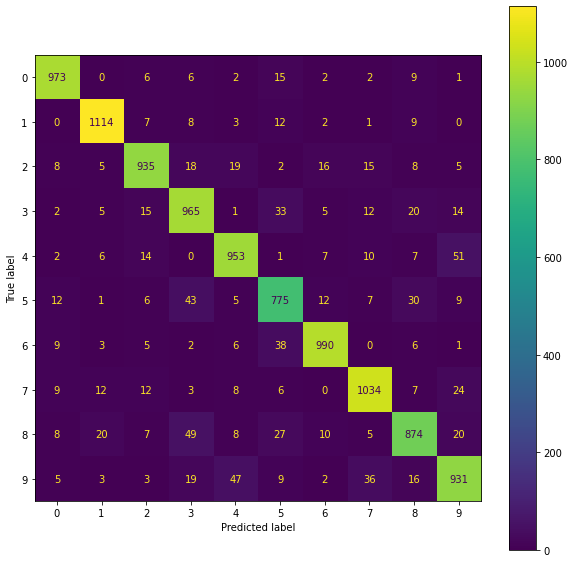

In [24]:
get_conf_matrix(mnist_2, X_test, y_test, labels)

In [60]:
# 3-слойный персептрон

np.random.seed(3183)

mnist_3 = Net()
mnist_3.add(Linear(784, 128))
mnist_3.add(Relu())
mnist_3.add(Linear(128, 128))
mnist_3.add(Relu())
mnist_3.add(Linear(128, 10))
mnist_3.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_3, loss)))
for i in range(n_epochs):
    train_epoch(mnist_3, X_train, y_train, loss)
    l_train, acc_tr = get_loss_acc(X_train, y_train, mnist_3, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, mnist_3, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=16.203653122941553, accuracy=0.09776666666666667: 
1: loss=11.585432944749666, accuracy=0.3556666666666667: 
2: loss=11.430526970540672, accuracy=0.3666833333333333: 
3: loss=10.365440049120894, accuracy=0.4119: 
4: loss=10.066706197194637, accuracy=0.42765: 
5: loss=9.944689008511018, accuracy=0.43375: 
6: loss=9.88334099398447, accuracy=0.43546666666666667: 
7: loss=9.81732442321889, accuracy=0.43851666666666667: 
8: loss=9.774405616562884, accuracy=0.4401833333333333: 
9: loss=9.736452277369192, accuracy=0.4416: 
10: loss=9.704445766638454, accuracy=0.4428666666666667: 
11: loss=9.67662413585976, accuracy=0.44275: 
12: loss=9.653027007749342, accuracy=0.44256666666666666: 
13: loss=9.627176690915787, accuracy=0.4431: 
14: loss=9.605849024181444, accuracy=0.44388333333333335: 
15: loss=9.585396939815787, accuracy=0.44455: 
16: loss=9.568052355350876, accuracy=0.4447833333333333: 
17: loss=9.552519959485466, accuracy=0.4451833333333333: 
18: loss=9.538636704730317, accura

Сравним точность 3-слойного перспетрона при изменении количества нейронов с 128 до 512.

In [25]:
# 3-слойный персептрон

np.random.seed(3183)

mnist_3 = Net()
mnist_3.add(Linear(784, 512))
mnist_3.add(Relu())
mnist_3.add(Linear(512, 512))
mnist_3.add(Relu())
mnist_3.add(Linear(512, 10))
mnist_3.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_3, loss)))
for i in range(n_epochs):
    train_epoch(mnist_3, X_train, y_train, loss)
    l_train, acc_tr = get_loss_acc(X_train, y_train, mnist_3, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, mnist_3, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=15.16777186606565, accuracy=0.12850793650793652: 
1: loss=5.7337603279611455, accuracy=0.6346666666666667: 
2: loss=3.8546025112776596, accuracy=0.7408253968253968: 
3: loss=3.366066734760173, accuracy=0.7775873015873016: 
4: loss=3.120988369178697, accuracy=0.7955555555555556: 
5: loss=2.937284824781472, accuracy=0.8088888888888889: 
6: loss=1.7626725366391445, accuracy=0.8573650793650793: 
7: loss=1.2856680694271874, accuracy=0.8931428571428571: 
8: loss=1.1399104571243, accuracy=0.9046349206349207: 
9: loss=1.034974267869226, accuracy=0.9126984126984127: 
10: loss=0.9613686629525685, accuracy=0.9186984126984127: 
11: loss=0.9034208016032808, accuracy=0.9227936507936508: 
12: loss=0.8563474030725365, accuracy=0.9261269841269841: 
13: loss=0.8174429662924362, accuracy=0.9287301587301587: 
14: loss=0.7796979155776228, accuracy=0.9319047619047619: 
15: loss=0.7391539992089596, accuracy=0.9356190476190476: 
16: loss=0.7059316979376553, accuracy=0.937936507936508: 
17: loss=0

Как видно, увеличение нейронов привело к увеличению точности с 53% до 96%.

### Графики loss и accuracy для обучающей и тестовой выборки для 3-слойного персептрона.

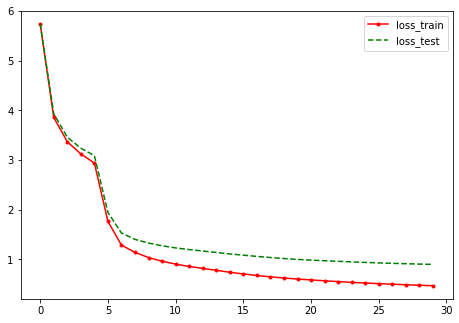

In [26]:
# loss на обучающей и тестовой выборке

draw(n_epochs, [loss_train, loss_test], 'loss_train', 'loss_test')

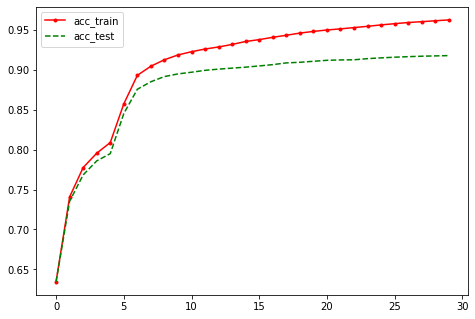

In [27]:
# accuracy на обучающей и тестовой выборке

draw(n_epochs, [acc_train, acc_test], 'acc_train', 'acc_test')

Точность 3-слойной модели с функцией активацией Relu() на обучающей и тестовой выборке:

In [28]:
# 3-layer model
print("Training: loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, mnist_3)))
print("Test: loss={}, accuracy={}: ".format(*get_loss_acc(X_test, y_test, mnist_3)))

Training: loss=0.46891364177358846, accuracy=0.9626666666666667: 
Test: loss=0.8973767520593314, accuracy=0.9179047619047619: 


### Матрица неточности для 3-слойного персептрона

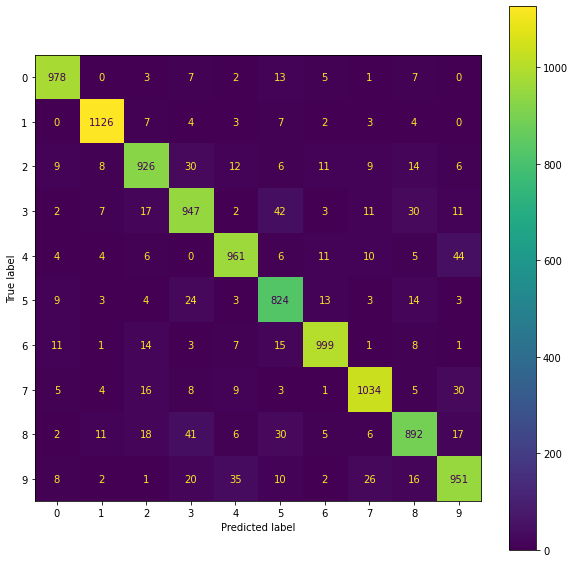

In [29]:
get_conf_matrix(mnist_3, X_test, y_test, labels)

### FashionMNIST

In [30]:
df_train = pd.read_csv('./datasets/fashion-mnist_train.csv')
df_test = pd.read_csv('./datasets/fashion-mnist_test.csv')

In [31]:
y_train = df_train.label
X_train = df_train.drop('label', axis=1)
y_test = df_test.label
X_test = df_test.drop('label', axis=1)

In [32]:
X_train.shape

(60000, 784)

In [39]:
# 1-слойный персептрон
fashion_1 = Net()
fashion_1.add(Linear(784, 10))
fashion_1.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, fashion_1, loss)))
for i in range(n_epochs):
    train_epoch(fashion_1, X_train, y_train, loss, 32, 0.0002)
    l_train, acc_tr = get_loss_acc(X_train, y_train, fashion_1, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, fashion_1, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=15.90035758580421, accuracy=0.11895: 
1: loss=10.101091232080535, accuracy=0.44471666666666665: 
2: loss=9.600981549873213, accuracy=0.47596666666666665: 
3: loss=9.64077252602665, accuracy=0.47405: 
4: loss=9.601888403670143, accuracy=0.4764: 
5: loss=9.542421133801842, accuracy=0.47935: 
6: loss=9.56761865926453, accuracy=0.47741666666666666: 
7: loss=9.526909398259125, accuracy=0.48036666666666666: 
8: loss=9.515665415785861, accuracy=0.4807666666666667: 
9: loss=9.5145954047238, accuracy=0.4812: 
10: loss=8.148610616561458, accuracy=0.5519666666666667: 
11: loss=7.776398014338643, accuracy=0.5749666666666666: 
12: loss=7.809996513084554, accuracy=0.5733333333333334: 
13: loss=7.780157109109741, accuracy=0.5752333333333334: 
14: loss=7.727718530638974, accuracy=0.5785: 
15: loss=7.753633614864854, accuracy=0.5764666666666667: 
16: loss=7.766274579242875, accuracy=0.5763166666666667: 
17: loss=7.730222924486213, accuracy=0.57815: 
18: loss=7.801465364058164, accuracy=0.5

### Графики loss и accuracy для обучающей и тестовой выборки для 1-слойного персептрона.

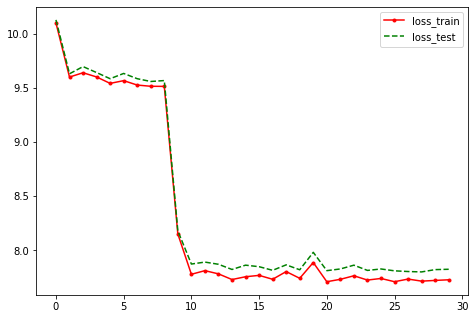

In [40]:
# loss на обучающей и тестовой выборке

draw(n_epochs, [loss_train, loss_test], 'loss_train', 'loss_test')

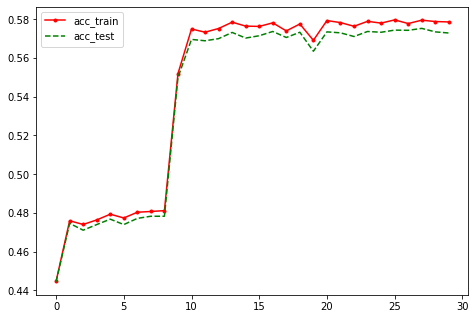

In [41]:
# accuracy на обучающей и тестовой выборке

draw(n_epochs, [acc_train, acc_test], 'acc_train', 'acc_test')

Точность 1-слойной модели на обучающей и тестовой выборке:

In [42]:
# 1-layer model
print("Training: loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, fashion_1)))
print("Test: loss={}, accuracy={}: ".format(*get_loss_acc(X_test, y_test, fashion_1)))

Training: loss=7.725521275026752, accuracy=0.5786166666666667: 
Test: loss=7.8227599184189955, accuracy=0.5729: 


Низкая точность следует из того, что однослойной модели не хватает, чтобы распознать одежду.

### Матрица неточности для 1-слойного персептрона

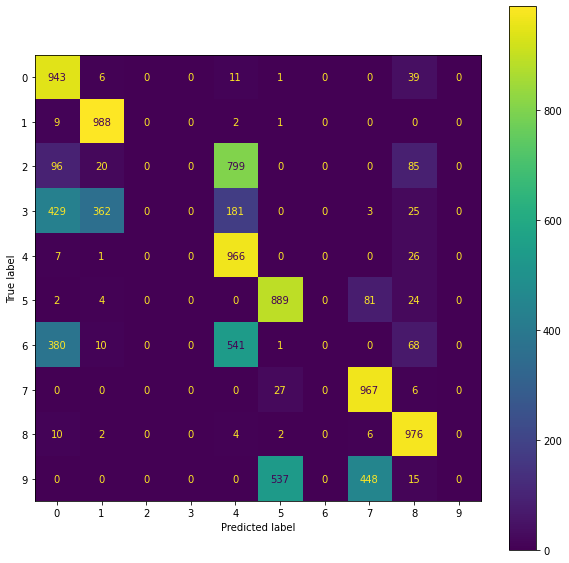

In [43]:
get_conf_matrix(fashion_1, X_test, y_test, labels)

In [56]:
# 2-слойный персептрон с функцией активации Relu()

fashion_2 = Net()
fashion_2.add(Linear(784, 128 ))
fashion_2.add(Relu())
fashion_2.add(Linear(128 , 10))
fashion_2.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, fashion_2, loss)))
for i in range(n_epochs):
    train_epoch(fashion_2, X_train, y_train, loss, 32, 0.0003)
    l_train, acc_tr = get_loss_acc(X_train, y_train, fashion_2, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, fashion_2, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=16.52873013654011, accuracy=0.08093333333333333: 
1: loss=6.650867057160149, accuracy=0.62605: 
2: loss=4.93090546847519, accuracy=0.71135: 
3: loss=0.852304589020832, accuracy=0.7481166666666667: 
4: loss=0.5812704415277467, accuracy=0.8037833333333333: 
5: loss=0.5149863218528068, accuracy=0.8234: 
6: loss=0.47904159591956597, accuracy=0.8330166666666666: 
7: loss=0.45508145368380293, accuracy=0.8398333333333333: 
8: loss=0.4355349296070701, accuracy=0.8455666666666667: 
9: loss=0.42209821308727813, accuracy=0.8501833333333333: 
10: loss=0.4105225486023925, accuracy=0.8538: 
11: loss=0.40018406324239975, accuracy=0.8570666666666666: 
12: loss=0.3908768202144654, accuracy=0.8603833333333334: 
13: loss=0.38381429554532304, accuracy=0.8619666666666667: 
14: loss=0.3779982370380146, accuracy=0.8633833333333333: 
15: loss=0.37054369389981096, accuracy=0.8663166666666666: 
16: loss=0.3647425298274605, accuracy=0.8681833333333333: 
17: loss=0.36026356268825815, accuracy=0.86926

### Графики loss и accuracy для обучающей и тестовой выборки для 2-слойного персептрона.

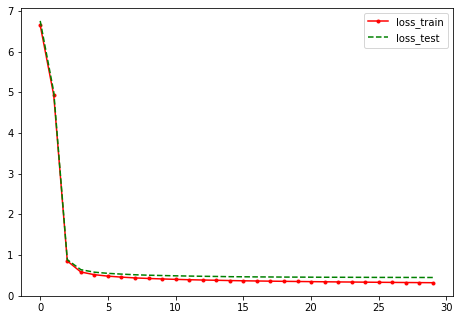

In [57]:
# loss на обучающей и тестовой выборке

draw(n_epochs, [loss_train, loss_test], 'loss_train', 'loss_test')

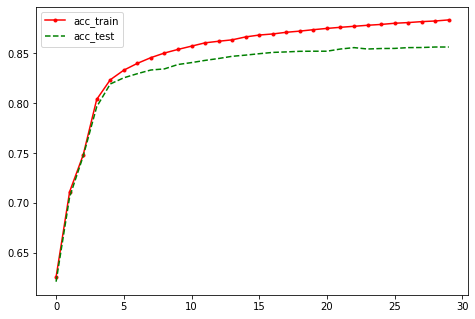

In [58]:
# accuracy на обучающей и тестовой выборке

draw(n_epochs, [acc_train, acc_test], 'acc_train', 'acc_test')

Точность 2-слойной модели с функцией активацией Relu() на обучающей и тестовой выборке:

In [63]:
# 2-layer model with Relu()
print("Training: loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, fashion_2)))
print("Test: loss={}, accuracy={}: ".format(*get_loss_acc(X_test, y_test, fashion_2)))

Training: loss=0.3176699274456983, accuracy=0.88335: 
Test: loss=0.4459091864422764, accuracy=0.8562: 


### Матрица неточности для 2-слойного персептрона

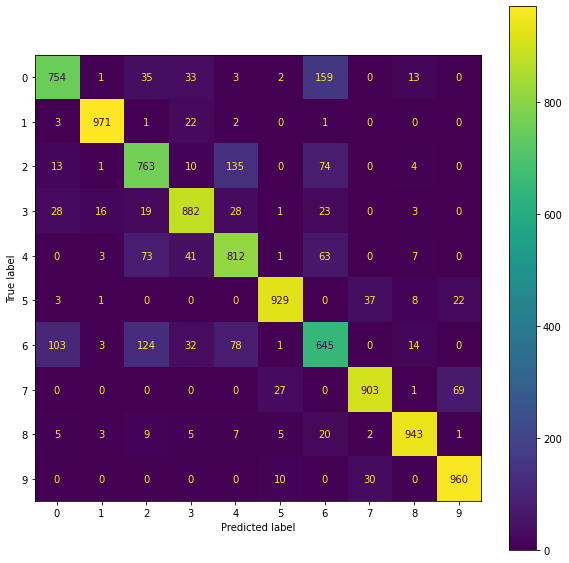

In [64]:
get_conf_matrix(fashion_2, X_test, y_test, labels)

In [49]:
# 3-слойный персептрон

#np.random.seed(3183)

fashion_3 = Net()
fashion_3.add(Linear(784, 40))
fashion_3.add(Relu())
fashion_3.add(Linear(40, 40))
fashion_3.add(Relu())
fashion_3.add(Linear(40, 10))
fashion_3.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, fashion_3, loss)))
for i in range(n_epochs):
    train_epoch(fashion_3, X_train, y_train, loss, 32, 0.0002)
    l_train, acc_tr = get_loss_acc(X_train, y_train, fashion_3, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, fashion_3, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=16.635224170642346, accuracy=0.059583333333333335: 
1: loss=4.46943466639544, accuracy=0.6486166666666666: 
2: loss=2.442406771165343, accuracy=0.7346: 
3: loss=0.7146880234267716, accuracy=0.7691: 
4: loss=0.6131028134852045, accuracy=0.79905: 
5: loss=0.5736604087259844, accuracy=0.8085666666666667: 
6: loss=0.5403327084032068, accuracy=0.81845: 
7: loss=0.5167679846590039, accuracy=0.8255166666666667: 
8: loss=0.4964395039468424, accuracy=0.83085: 
9: loss=0.4837995054008363, accuracy=0.8348833333333333: 
10: loss=0.46708777252932665, accuracy=0.8395833333333333: 
11: loss=0.4574447937107764, accuracy=0.8422833333333334: 
12: loss=0.4481896138329927, accuracy=0.8452166666666666: 
13: loss=0.43931211109982116, accuracy=0.8472: 
14: loss=0.4333610048435085, accuracy=0.8486166666666667: 
15: loss=0.4278703726556122, accuracy=0.8503666666666667: 
16: loss=0.42281576271090787, accuracy=0.8522166666666666: 
17: loss=0.4167491247464598, accuracy=0.8540333333333333: 
18: loss=0

Сравним точность 3-слойного перспетрона при изменении количества нейронов с 40 до 128

In [50]:
# 3-слойный персептрон

#np.random.seed(3183)

fashion_3 = Net()
fashion_3.add(Linear(784, 128))
fashion_3.add(Relu())
fashion_3.add(Linear(128, 128))
fashion_3.add(Relu())
fashion_3.add(Linear(128, 10))
fashion_3.add(Softmax())
loss = CrossEntropyLoss()

loss_test = []
acc_test = []
loss_train = []
acc_train = []

n_epochs = 30
print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, fashion_3, loss)))
for i in range(n_epochs):
    train_epoch(fashion_3, X_train, y_train, loss, 32, 0.0002)
    l_train, acc_tr = get_loss_acc(X_train, y_train, fashion_3, loss)
    print("{}: loss={}, accuracy={}: ".format(i + 1, l_train, acc_tr))
    l_test, acc_ts = get_loss_acc(X_test, y_test, fashion_3, loss)
    loss_train.append(l_train)
    acc_train.append(acc_tr)
    loss_test.append(l_test)
    acc_test.append(acc_ts)

Initial loss=16.021018786017517, accuracy=0.09235: 
1: loss=4.524658974326852, accuracy=0.7014666666666667: 
2: loss=0.8696796126782206, accuracy=0.7887833333333333: 
3: loss=0.6183568309043137, accuracy=0.8123333333333334: 
4: loss=0.5444959578538273, accuracy=0.8244166666666667: 
5: loss=0.49570521660507216, accuracy=0.8345333333333333: 
6: loss=0.46383577480177185, accuracy=0.8429166666666666: 
7: loss=0.4413974510615532, accuracy=0.8485333333333334: 
8: loss=0.4233008053795846, accuracy=0.8530666666666666: 
9: loss=0.4101468229399959, accuracy=0.85695: 
10: loss=0.3980621203320219, accuracy=0.8607666666666667: 
11: loss=0.3873424222832851, accuracy=0.86365: 
12: loss=0.3784773493753024, accuracy=0.8654: 
13: loss=0.37057151030285906, accuracy=0.8678166666666667: 
14: loss=0.36428646482132127, accuracy=0.86975: 
15: loss=0.35736783821890283, accuracy=0.8718833333333333: 
16: loss=0.35072831215884986, accuracy=0.87395: 
17: loss=0.34567916390996406, accuracy=0.8756666666666667: 
18: 

Как видно, увеличение нейронов привело к увеличению точности с 87% до 89%.

### Графики loss и accuracy для обучающей и тестовой выборки для 3-слойного персептрона.

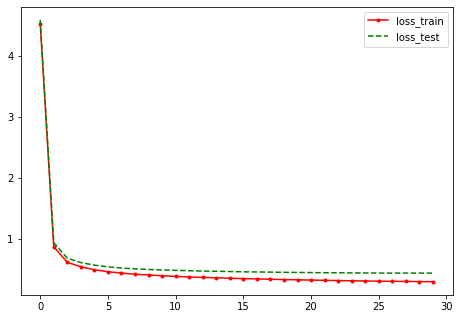

In [51]:
# loss на обучающей и тестовой выборке

draw(n_epochs, [loss_train, loss_test], 'loss_train', 'loss_test')

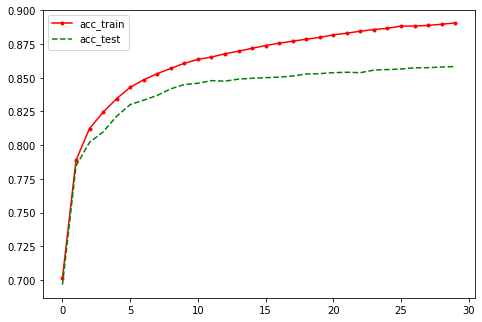

In [52]:
# accuracy на обучающей и тестовой выборке

draw(n_epochs, [acc_train, acc_test], 'acc_train', 'acc_test')

Точность 3-слойной модели с функцией активацией Relu() на обучающей и тестовой выборке:

In [53]:
# 3-layer model
print("Training: loss={}, accuracy={}: ".format(*get_loss_acc(X_train, y_train, fashion_3)))
print("Test: loss={}, accuracy={}: ".format(*get_loss_acc(X_test, y_test, fashion_3)))

Training: loss=0.30035174628757366, accuracy=0.89075: 
Test: loss=0.441015479059062, accuracy=0.8583: 


### Матрица неточности для 3-слойного персептрона

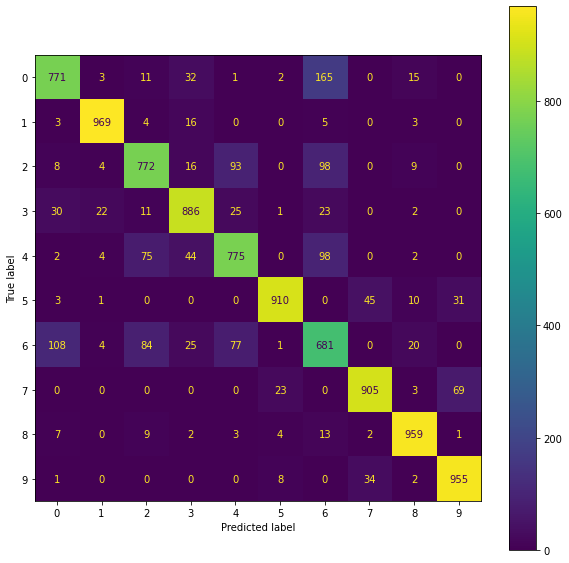

In [54]:
get_conf_matrix(fashion_3, X_test, y_test, labels)